In [47]:
import importlib

# Imports
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt 
import defaults
importlib.reload(defaults)

<module 'defaults' from 'C:\\Users\\20223037\\OneDrive - TU Eindhoven\\Documents\\school\\jaar2\\Biomedical\\8CC00-GroupAssignment\\defaults.py'>

In [48]:
# Read data and construct dataframe

df = pd.read_csv('datasets/tested_molecules.csv')

df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition
0,C=C(C)c1nc(N)nc(N)n1,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0


In [49]:
# Load the dataset
df = pd.read_csv('datasets/tested_molecules.csv')  # Replace with your file path

# Function to compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return defaults.get_mol_descriptors(mol)
    else:
        return {key: None for key in defaults.x_data}

df['Descriptors'] = df['SMILES'].apply(compute_descriptors)
descriptors_df = pd.json_normalize(df['Descriptors'])
df = pd.concat([df, descriptors_df], axis=1).drop(columns=['Descriptors'])
df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MolWt,TPSA,MolLogP,NumHDonors,NumHAcceptors,fr_NH1,fr_benzene,fr_phenol,CalcNumRotatableBonds
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,90.71,0.06910,2,5,0,0,0,1
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,39.44,3.23272,0,3,0,1,0,3
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,58.20,0.76110,2,2,2,0,0,8
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,58.17,0.55792,0,4,0,1,0,3
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,44.00,1.03540,0,4,0,0,0,4


In [50]:
# Convert SMILES to fingerprints, so we have usable data training

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return list(fp)
    else:
        return [0] * 1024
    
df['Fingerprint'] = df['SMILES'].apply(smiles_to_fingerprint)

df.head()

,SMILES,PKM2_inhibition,ERK2_inhibition,MolWt,TPSA,MolLogP,NumHDonors,NumHAcceptors,fr_NH1,fr_benzene,fr_phenol,CalcNumRotatableBonds,Fingerprint
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,90.71,0.06910,2,5,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,39.44,3.23272,0,3,0,1,0,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,58.20,0.76110,2,2,2,0,0,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,58.17,0.55792,0,4,0,1,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,44.00,1.03540,0,4,0,0,0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


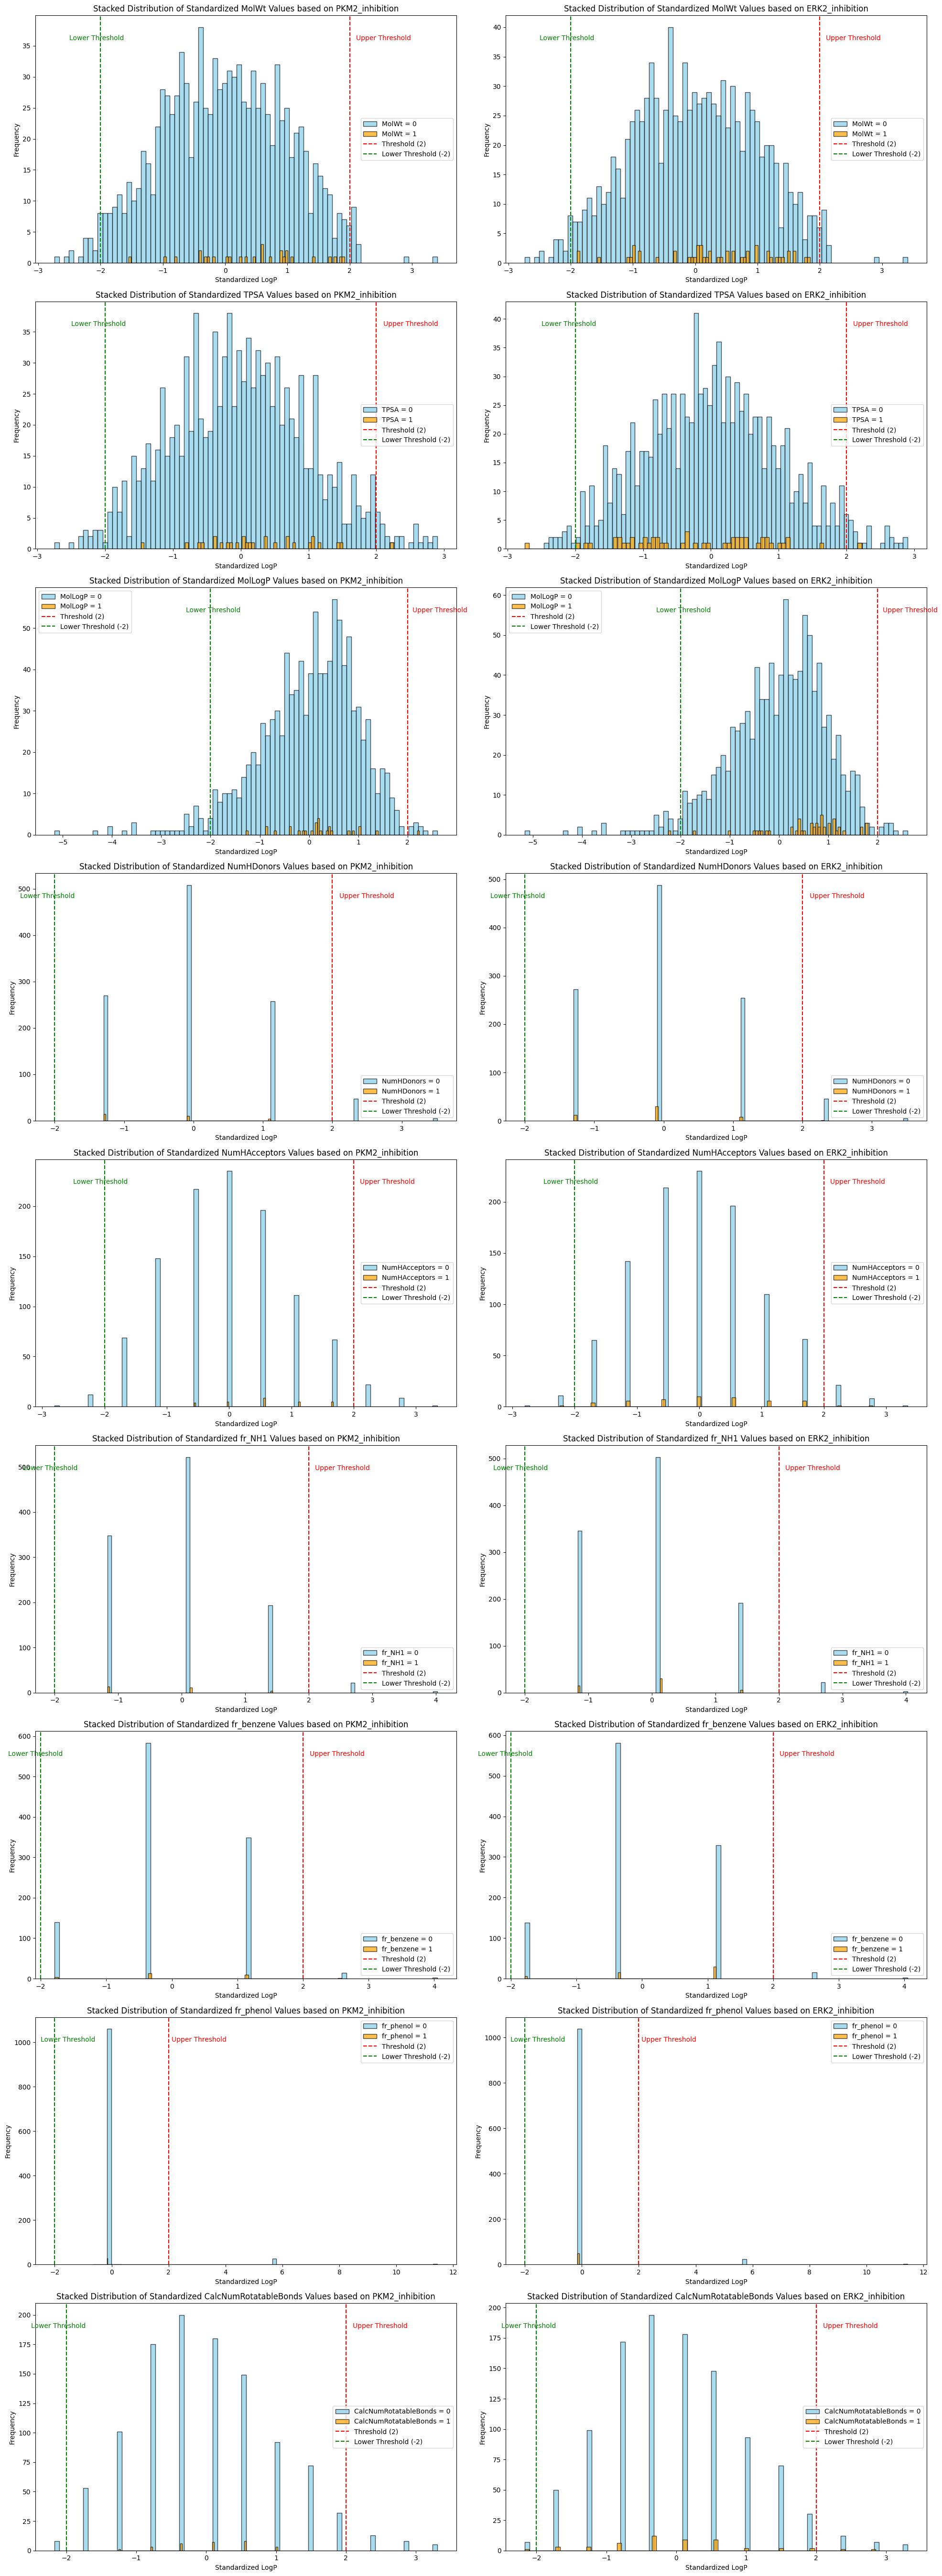

In [51]:
column_names = defaults.x_data
z_scores = df[defaults.x_data].apply(zscore)
rows_names = defaults.y_data

threshold = 2
lower_threshold = -2

# Create subplots for each variable
fig, axs = plt.subplots(len(column_names), len(rows_names), figsize=(20, len(column_names)*6))

for i, inhibition_enzyme in enumerate(defaults.y_data):
    # Iterate over each variable name
    for j, column_name in enumerate(column_names):
        # Compute z-scores for the specified column
        #z_scores = df[column_name].apply(zscore)
        
        # Extract the column values for PKM2_inhibition
        PKM2_inhibition = df[inhibition_enzyme]
        
        # Identify outliers based on z-scores exceeding the thresholds
        outliers = (z_scores.abs() > threshold).any(axis=1)
        
        # Extract z-scores for the column of interest
        z_scores_column = z_scores[column_name]
        
        # Define colors for the bars based on the ratio
        colors = PKM2_inhibition.map({0: 'skyblue', 1: 'orange'})
        
        # Plotting the histogram as a stacked bar histogram
        axs[j][i].hist(z_scores_column[PKM2_inhibition == 0], bins=80, color='skyblue', edgecolor='black', alpha=0.7, label=f'{column_name} = 0', stacked=True)
        axs[j][i].hist(z_scores_column[PKM2_inhibition == 1], bins=80, color='orange', edgecolor='black', alpha=0.7, label=f'{column_name} = 1', stacked=True)
        
        # Enhancing plot aesthetics and providing descriptive labels
        axs[j][i].set_title(f'Stacked Distribution of Standardized {column_name} Values based on {inhibition_enzyme}')
        axs[j][i].set_xlabel('Standardized LogP')
        axs[j][i].set_ylabel('Frequency')
        
        # Add vertical lines at the thresholds for visual reference
        axs[j][i].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
        axs[j][i].axvline(x=lower_threshold, color='green', linestyle='--', label=f'Lower Threshold ({lower_threshold})')
        
        # Indicate the presence of the thresholds
        axs[j][i].text(threshold + 0.1, axs[j][i].get_ylim()[1] * 0.9, 'Upper Threshold', color='red')
        axs[j][i].text(lower_threshold - 0.5, axs[j][i].get_ylim()[1] * 0.9, 'Lower Threshold', color='green')
        
        # Add a legend
        axs[j][i].legend()

plt.tight_layout()
plt.show()

In [52]:
# change outliers to NaN
df1 = df[defaults.x_data]

mask = (z_scores.abs() > 2)
mask.head()

df1[mask] = pd.NA

df1.head()

C:\Users\20223037\AppData\Local\Temp\ipykernel_1736\676677244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[mask] = pd.NA
C:\Users\20223037\AppData\Local\Temp\ipykernel_1736\676677244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[mask] = pd.NA


,MolWt,TPSA,MolLogP,NumHDonors,NumHAcceptors,fr_NH1,fr_benzene,fr_phenol,CalcNumRotatableBonds
0,NaN,90.71,0.06910,2.0,5.0,0.0,0.0,0.0,1.0
1,250.681,39.44,3.23272,0.0,3.0,0.0,1.0,0.0,3.0
2,210.277,58.20,0.76110,2.0,2.0,2.0,0.0,0.0,8.0
3,232.239,58.17,0.55792,0.0,4.0,0.0,1.0,0.0,3.0
4,226.663,44.00,1.03540,0.0,4.0,0.0,0.0,0.0,4.0


In [53]:
z_scores.head()

,MolWt,TPSA,MolLogP,NumHDonors,NumHAcceptors,fr_NH1,fr_benzene,fr_phenol,CalcNumRotatableBonds
0,-2.735972,0.761277,-1.811345,1.108443,-0.007504,-1.169279,-1.786669,-0.15587,-1.708990
1,-1.351495,-1.490608,0.651960,-1.295877,-1.124038,-1.169279,-0.328057,-0.15587,-0.797093
2,-1.913645,-0.666630,-1.272530,1.108443,-1.682305,1.427568,-1.786669,-0.15587,1.482650
3,-1.608083,-0.667948,-1.430733,-1.295877,-0.565771,-1.169279,-0.328057,-0.15587,-0.797093
4,-1.685663,-1.290323,-1.058950,-1.295877,-0.565771,-1.169279,-1.786669,-0.15587,-0.341144


In [54]:
fingerprint_data = df['SMILES'].apply(smiles_to_fingerprint)

finger_print = pd.DataFrame(fingerprint_data)

finger_print.head()
df2 = pd.DataFrame(finger_print['SMILES'].to_list(), columns=[f'Fingerprint_{i}' for i in range(len(finger_print['SMILES'][0]))])

merged_df = pd.concat([df2, df1, df], axis=1)
merged_df.head(50)

,Fingerprint_0,Fingerprint_1,Fingerprint_2,Fingerprint_3,Fingerprint_4,Fingerprint_5,Fingerprint_6,Fingerprint_7,Fingerprint_8,Fingerprint_9,...,MolWt,TPSA,MolLogP,NumHDonors,NumHAcceptors,fr_NH1,fr_benzene,fr_phenol,CalcNumRotatableBonds,Fingerprint
0,0,0,0,0,0,0,0,0,0,0,...,151.173,90.71,0.06910,2,5,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,0,0,1,0,0,0,0,0,0,...,250.681,39.44,3.23272,0,3,0,1,0,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,0,0,0,0,0,0,0,0,0,0,...,210.277,58.20,0.76110,2,2,2,0,0,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,0,0,0,0,0,0,0,0,0,...,232.239,58.17,0.55792,0,4,0,1,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,0,0,0,0,0,0,0,0,0,...,226.663,44.00,1.03540,0,4,0,0,0,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0,0,0,0,0,0,0,0,0,0,...,258.277,62.55,2.51460,1,3,1,1,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0,0,0,0,0,0,0,0,0,0,...,233.213,34.45,1.78810,0,2,1,0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,0,0,0,0,0,0,0,0,0,0,...,199.255,67.68,1.79240,2,5,1,0,0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8,0,1,0,0,0,0,0,0,0,0,...,221.220,92.15,0.01210,2,5,2,0,0,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,0,1,0,0,0,0,0,0,0,0,...,232.351,33.12,1.76460,2,1,2,1,0,4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [55]:
# Remove columns that have a Nah
dropped_df = merged_df.dropna()

In [56]:
dropped_df.to_csv('./datasets/prepared_data.csv')